In [42]:
import umap

import pandas as pd
import numpy as np
import networkx as nx

from datetime import datetime as dt
from scipy import stats
from scipy.spatial import distance
from itertools import permutations, combinations
from tqdm import tqdm
from annoy import AnnoyIndex

from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [3]:
df, embeds = read_preds('../data/ava-ts-lstm-attn/')

100%|██████████| 361/361 [00:17<00:00, 20.92it/s]


In [4]:
embeds.shape

(360300, 512)

In [5]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.domain}'], 1)

In [6]:
df_train = df[df.split=='train']

In [7]:
rows = []
for d in df_train.domain.unique():
    pdf = df_train[df_train.domain==d]
    lr = stats.linregress(pdf.decile, pdf.p_true)
    rows.append((d, lr.slope, lr.intercept, lr.rvalue, lr.pvalue))

In [8]:
ova_lr_df = pd.DataFrame(rows, columns=('domain', 'slope', 'intercept', 'r', 'p'))

In [9]:
ova_lr_df.sort_values('slope', ascending=False)

,domain,slope,intercept,r,p
9,buzzfeed.com,0.017344,0.660308,0.146107,1.459079e-92
3,foxnews.com,0.012805,0.186407,0.155502,1.349341e-104
7,dailycaller.com,0.005921,0.305369,0.067702,6.287558e-21
14,breitbart.com,0.001974,0.441768,0.018093,1.203438e-02
8,washingtonpost.com,0.001817,0.252170,0.020733,4.076108e-03
12,wsj.com,0.001134,0.337178,0.012165,9.209903e-02
6,apnews.com,0.001019,0.415121,0.010979,1.281613e-01
10,huffingtonpost.com,-0.000282,0.252881,-0.003559,6.220665e-01
2,npr.org,-0.002034,0.301009,-0.023195,1.340201e-03
4,bloomberg.com,-0.002521,0.463087,-0.023172,1.271326e-03


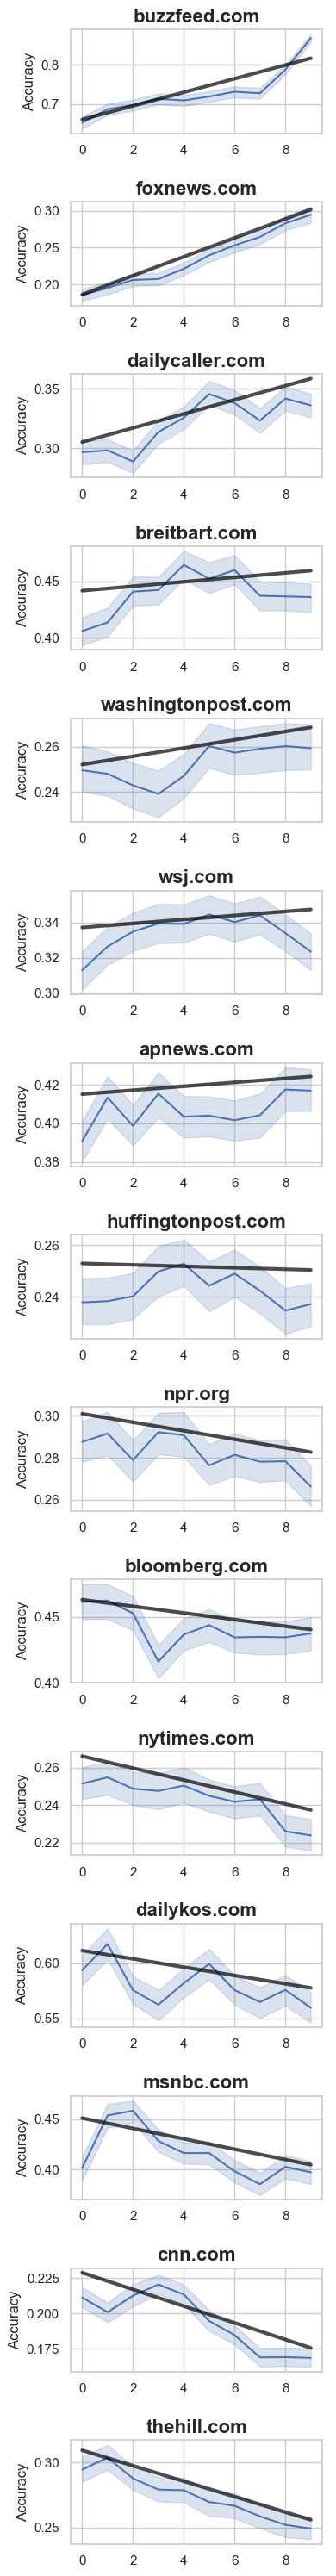

In [11]:
fig, axes = plt.subplots(len(ova_lr_df), 1, figsize=(4,30), dpi=100)

for i, r in enumerate(ova_lr_df.sort_values('slope', ascending=False).itertuples()):
    
    ax = axes[i]
    pdf = df[df.domain==r.domain].sort_values('decile')
    
    fitx = np.array([pdf.decile.min(), pdf.decile.max()])
    fity = r.slope * fitx + r.intercept
    
    sns.lineplot(x='decile', y='p_true', data=pdf, ax=ax)
    ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
    
    ax.set_title(r.domain, fontdict=dict(fontsize=16, fontweight='bold'))
    ax.set_xlabel(None)
    ax.set_ylabel('Accuracy')
    
plt.tight_layout(h_pad=2)

In [12]:
DOMAINS = list(df_train.domain.unique())

In [13]:
rows = []
for d1, d2 in tqdm(permutations(DOMAINS, 2)):
    pdf = df[df.domain==d1].sort_values('decile')
    d2p = pdf.apply(lambda r: r[f'p_{d2}'], 1)
    lr = stats.linregress(pdf.decile, d2p)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.rvalue, lr.pvalue))

210it [01:30,  2.38it/s]


In [63]:
ab_lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'r', 'p'))

In [69]:
ab_lr_df.sort_values('slope', ascending=False).head(10)

,d1,d2,slope,intercept,r,p
12,thehill.com,dailykos.com,0.003139,0.038104,0.083973,7.557636e-39
13,thehill.com,breitbart.com,0.002841,0.068061,0.069863,2.217221e-27
21,cnn.com,washingtonpost.com,0.002582,0.041597,0.097752,4.410630e-52
110,dailycaller.com,dailykos.com,0.002559,0.058159,0.055810,4.891047e-18
82,msnbc.com,dailykos.com,0.002417,0.044770,0.072771,1.424677e-29
22,cnn.com,buzzfeed.com,0.002262,0.019580,0.069926,1.992303e-27
153,huffingtonpost.com,breitbart.com,0.002220,0.045046,0.060550,5.865316e-21
147,huffingtonpost.com,dailycaller.com,0.002107,0.070369,0.055588,6.608044e-18
26,cnn.com,dailykos.com,0.002065,0.026946,0.067206,1.866283e-25
111,dailycaller.com,breitbart.com,0.002012,0.127574,0.033186,2.683835e-07


In [95]:
def plot_pairs(lr_df, w=4, h=20):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[df.domain==r.d1].sort_values('decile').copy()
        pdf['d2p'] = pdf.apply(lambda ri: ri[f'p_{r.d2}'], 1)

        fitx = np.array([pdf.decile.min(), pdf.decile.max()])
        fity = r.slope * fitx + r.intercept

        sns.lineplot(x='decile', y='d2p', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('d2 probability')

    plt.tight_layout(h_pad=2)
    plt.show()

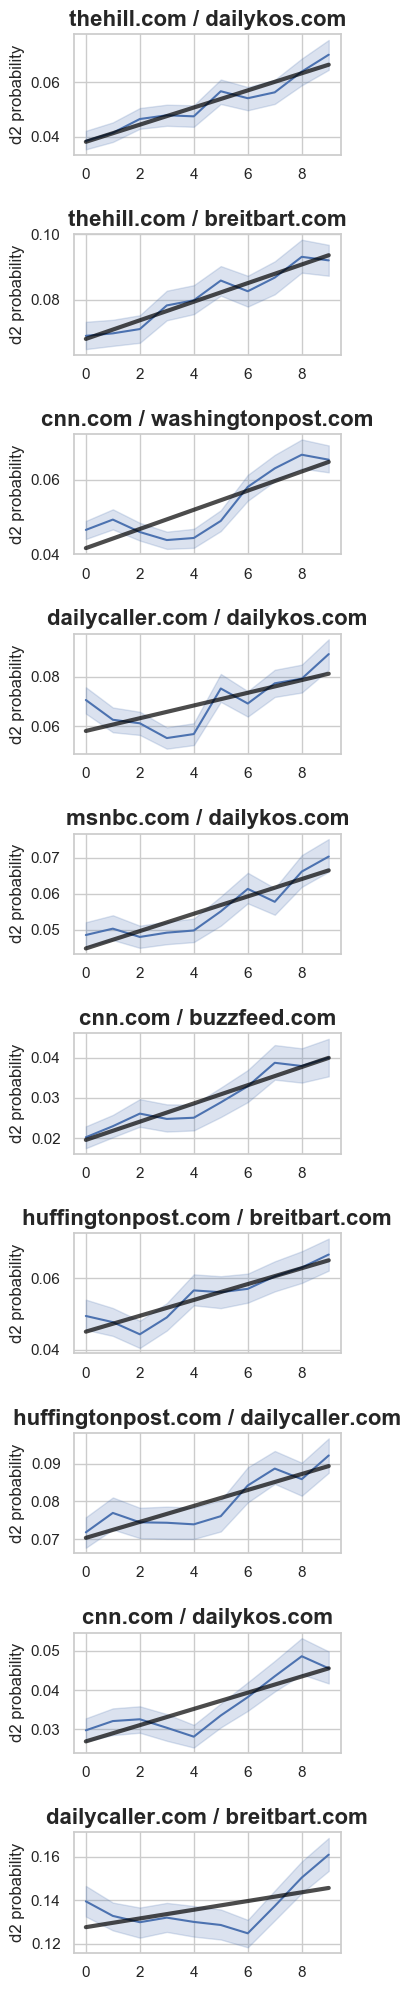

In [96]:
plot_pairs(ab_lr_df.sort_values('slope', ascending=False).head(10))

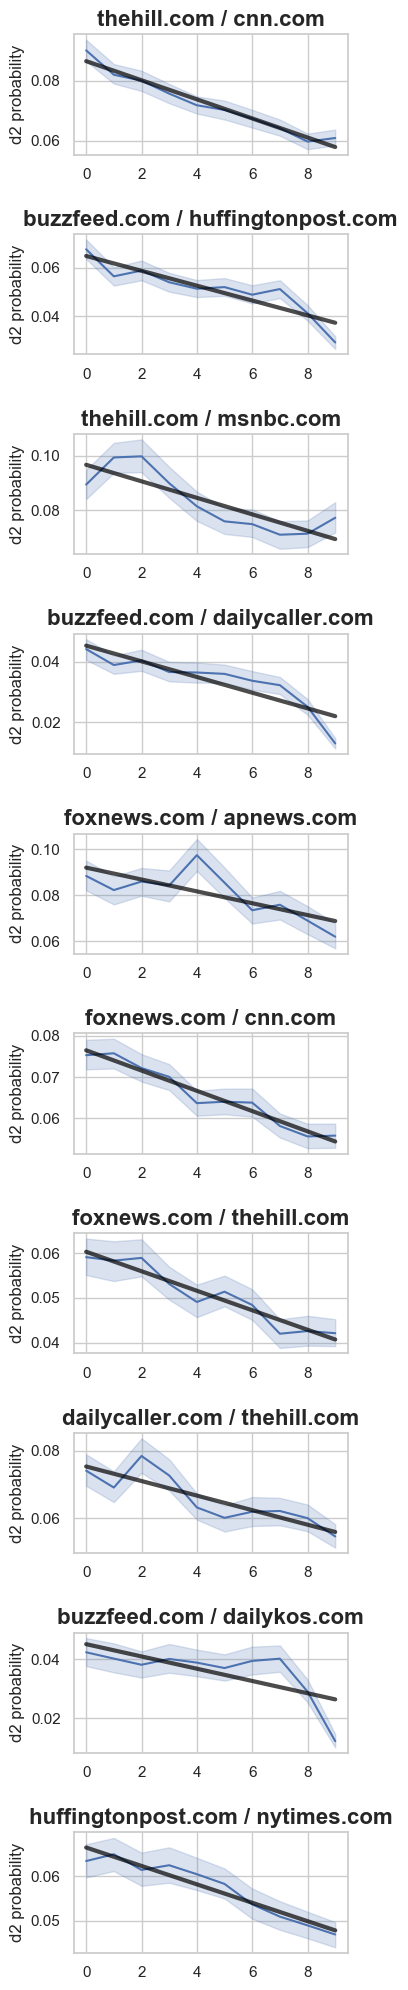

In [98]:
plot_pairs(ab_lr_df.sort_values('slope', ascending=True).head(10))

In [22]:
def mean_pwd(df1, df2):
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)
    return distance.cosine(v1, v2)

In [28]:
def mean_pwd_09(d1, d2):
    
    d0 = mean_pwd(
        df_train[(df_train.domain==d1)&(df_train.decile==0)],
        df_train[(df_train.domain==d2)&(df_train.decile==0)],
    )
    
    d9 = mean_pwd(
        df_train[(df_train.domain==d1)&(df_train.decile==9)],
        df_train[(df_train.domain==d2)&(df_train.decile==9)],
    )
    
    return d9 - d0

In [99]:
def mean_d2pt_09(d1, d2):
    
    pdf = df_train[df_train.domain==d1].sort_values('decile').copy()
    pdf['d2p'] = pdf.apply(lambda ri: ri[f'p_{d2}'], 1)
    
    return pdf[pdf.decile==9].d2p.mean() - pdf[pdf.decile==0].d2p.mean()

In [102]:
rows = []
for d1, d2 in tqdm(combinations(DOMAINS, 2)):
    d1, d2 = sorted([d1, d2])
    d = mean_d2pt_09(d1, d2)
    rows.append((d1, d2, d))

105it [00:36,  3.00it/s]


In [103]:
ab_df = pd.DataFrame(rows, columns=('d1', 'd2', 'd'))

In [104]:
lr_df = pd.read_json('thesis/data/ts-ab-lr.json', lines=True)

In [105]:
ab_df = ab_df.merge(lr_df, on=['d1', 'd2'])

In [110]:
ab_df['color'] = ab_df.d.apply(lambda s: 'red' if s < 0 else 'blue')
ab_df['width'] = abs(ab_df.d*100)**2

In [111]:
g = nx.Graph()
for r in ab_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [112]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


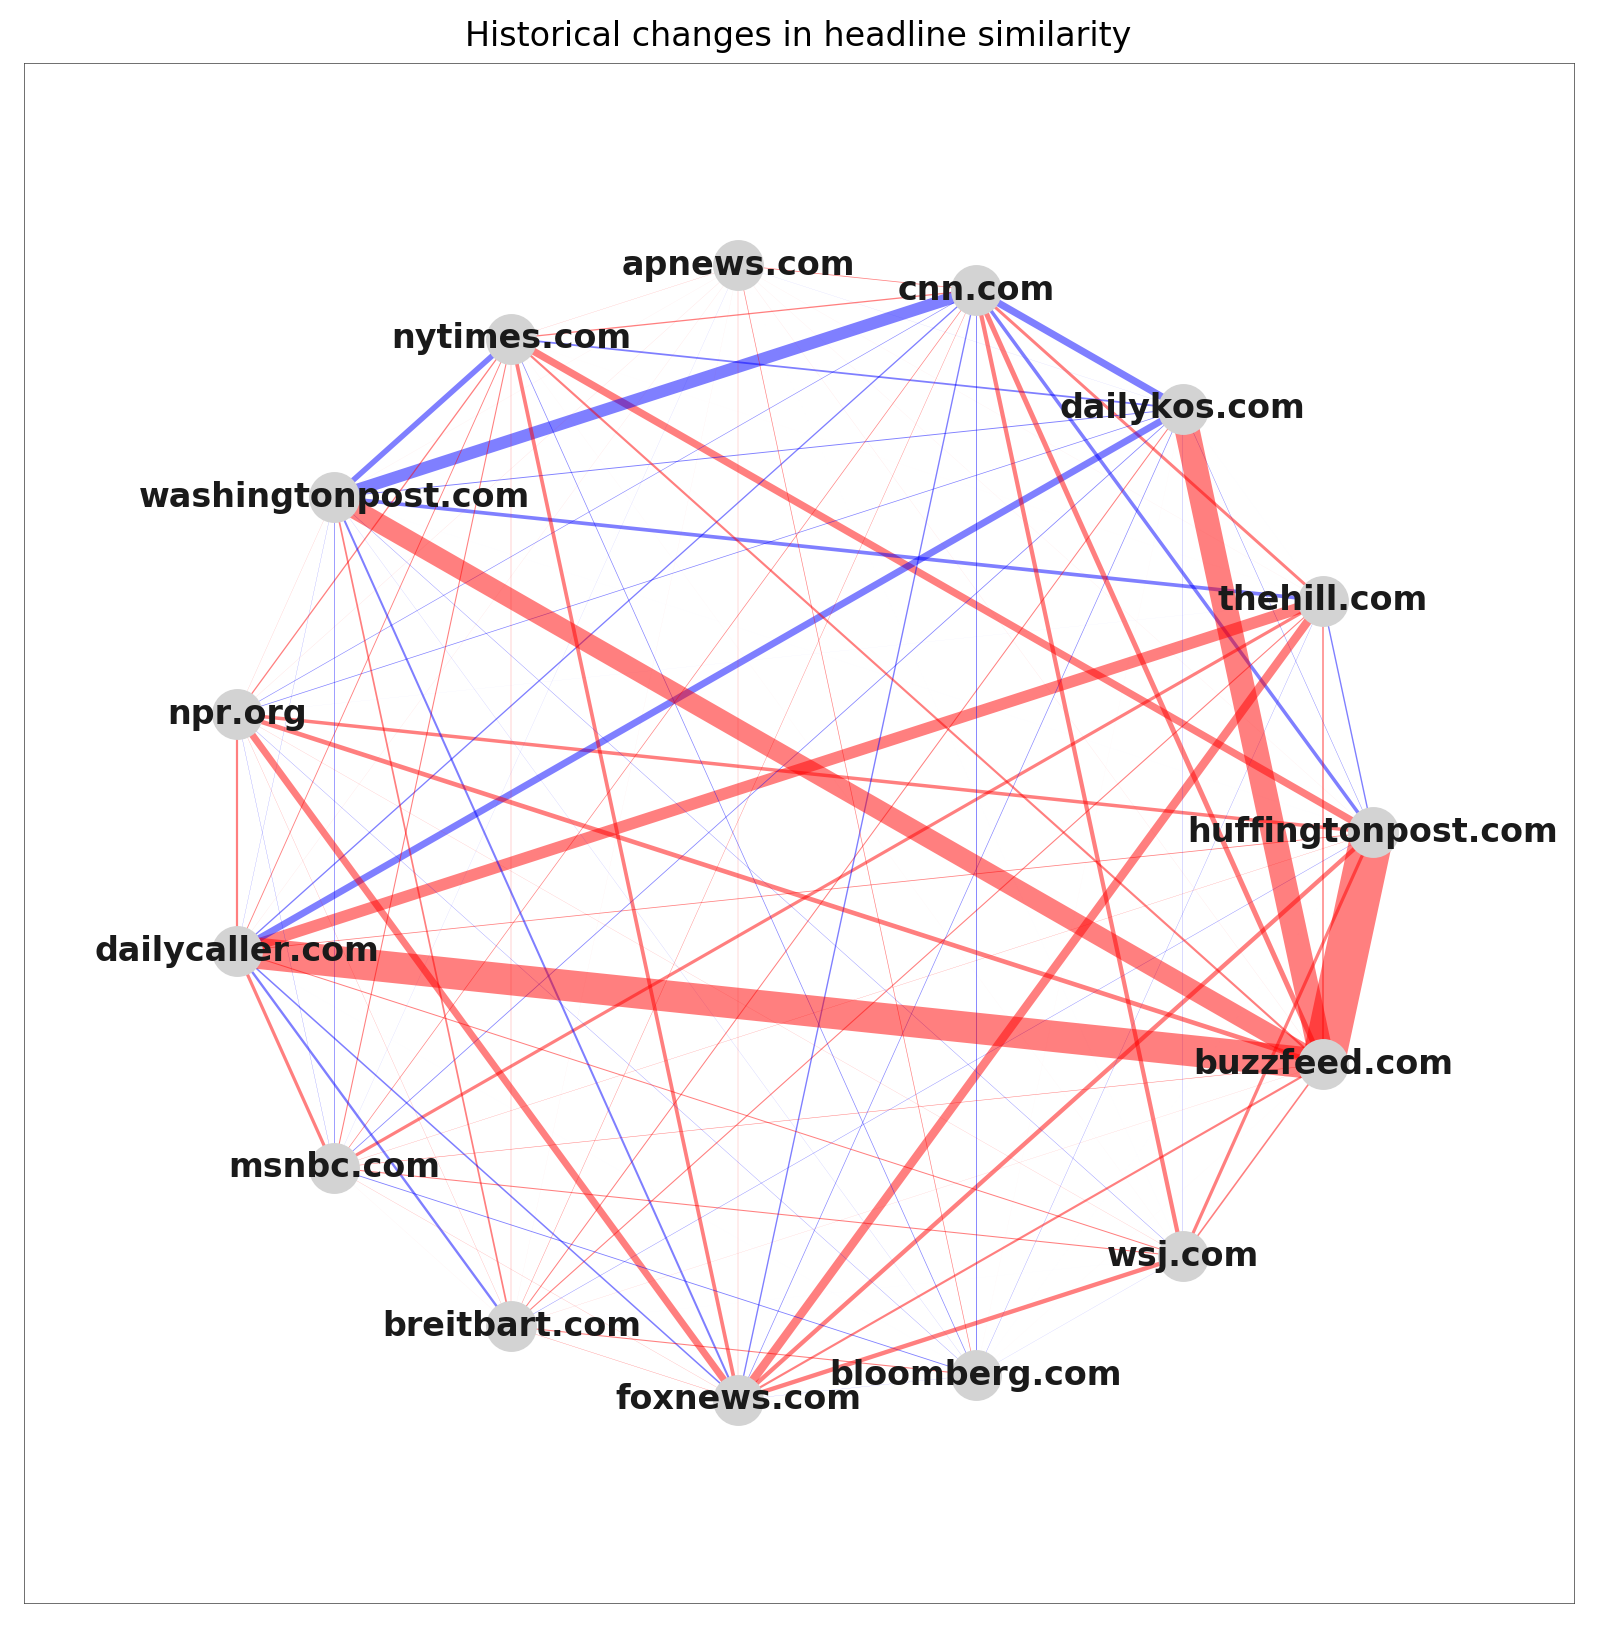

In [113]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')